In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Veri yolundan görüntü dosyalarını ve etiketleri oku
        for label, class_dir in enumerate(os.listdir(root_dir)):
            class_path = os.path.join(root_dir, class_dir)
            for image_file in os.listdir(class_path):
                self.image_paths.append(os.path.join(class_path, image_file))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Veri dönüşümleri (224x224 giriş boyutu)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset ve DataLoader
DATA_DIR = r'Dataset\lung_colon_image_set\lung_image_sets'  # Verinin bulunduğu ana klasör
dataset = CustomDataset(DATA_DIR, transform=transform)
data_loader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=0)


In [7]:
from torchvision.models import resnet50, ResNet50_Weights
weights = ResNet50_Weights.DEFAULT  # En güncel varsayılan ağırlıklar
resnet = resnet50(weights=weights)
resnet.fc = nn.Identity()  # Fully connected katman kaldırıldı
resnet = resnet.to(device)
resnet.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
import torch.nn as nn

# EfficientNetB7 Modelinin Tanımlanması
weights = EfficientNet_B7_Weights.DEFAULT
efficientnet = efficientnet_b7(weights=weights)  # Model oluşturuluyor
efficientnet.classifier = nn.Identity()  # Fully connected katman kaldırılıyor
efficientnet = efficientnet.to(device)
efficientnet.eval()  # Modeli değerlendirme moduna alıyoruz


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [11]:
resnet_features = []
efficientnet_features = []
labels = []

with torch.no_grad():
    for images, lbls in data_loader:
        images = images.to(device)

        # ResNet50
        resnet_output = resnet(images)
        resnet_features.append(resnet_output.cpu().numpy())

        # EfficientNetB7
        efficientnet_output = efficientnet(images)  # efficientnet_b7 yerine efficientnet kullanılıyor
        efficientnet_features.append(efficientnet_output.cpu().numpy())

        # Etiketleri Kaydet
        labels.append(lbls.numpy())

resnet_features = np.concatenate(resnet_features, axis=0)
efficientnet_features = np.concatenate(efficientnet_features, axis=0)
labels = np.concatenate(labels, axis=0)

np.save("resnet_features.npy", resnet_features)
np.save("efficientnet_features.npy", efficientnet_features)
np.save("labels.npy", labels)


In [12]:
from sklearn.model_selection import train_test_split

# Özelliklerin Birleştirilmesi
combined_features = np.concatenate([resnet_features, efficientnet_features], axis=1)

In [13]:
# Veriyi Eğitim ve Test Setlerine Ayırma
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.2, random_state=48)

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

In [15]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=48)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)

# SVM
svm_model = SVC(kernel='rbf', probability=True, random_state=48)
svm_model.fit(X_train, y_train)
svm_y_pred = svm_model.predict(X_test)

# XGBoost
xgb_model = XGBClassifier(eval_metric='logloss', random_state=48)
xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=48)
dt_model.fit(X_train, y_train)
dt_y_pred = dt_model.predict(X_test)


models = {
    "Random Forest": (rf_model, rf_y_pred),
    "SVM": (svm_model, svm_y_pred),
    "XGBoost": (xgb_model, xgb_y_pred),
    "Decision Tree": (dt_model, dt_y_pred)
}

Model: Random Forest
Accuracy: 0.9763333333333334
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       937
           1       0.99      1.00      1.00      1029
           2       0.97      0.97      0.97      1034

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



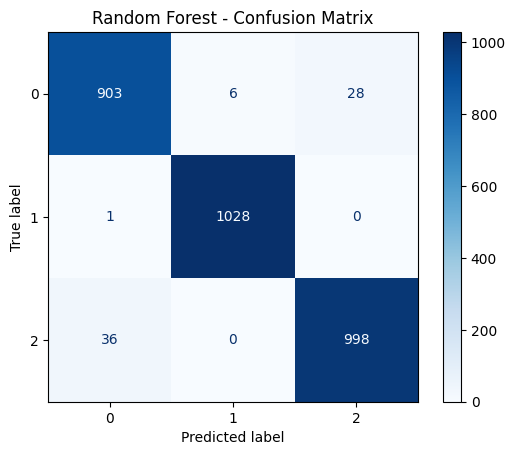

Model: SVM
Accuracy: 0.989
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       937
           1       1.00      1.00      1.00      1029
           2       0.98      0.99      0.98      1034

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



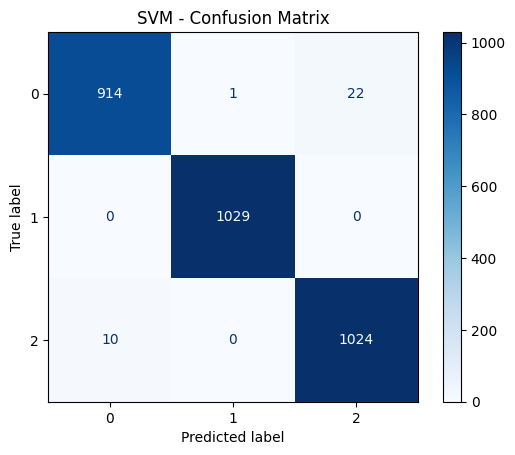

Model: XGBoost
Accuracy: 0.9916666666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       937
           1       1.00      1.00      1.00      1029
           2       0.99      0.99      0.99      1034

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



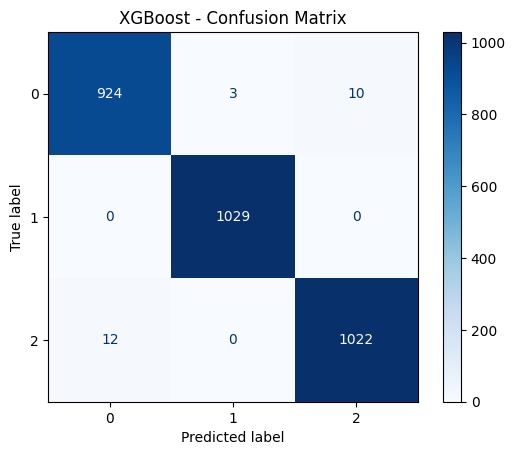

Model: Decision Tree
Accuracy: 0.9406666666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       937
           1       0.98      0.98      0.98      1029
           2       0.94      0.92      0.93      1034

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



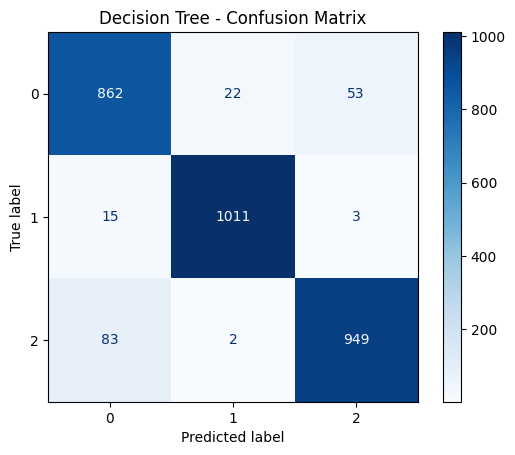

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for model_name, (model, y_pred) in models.items():
    print(f"Model: {model_name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

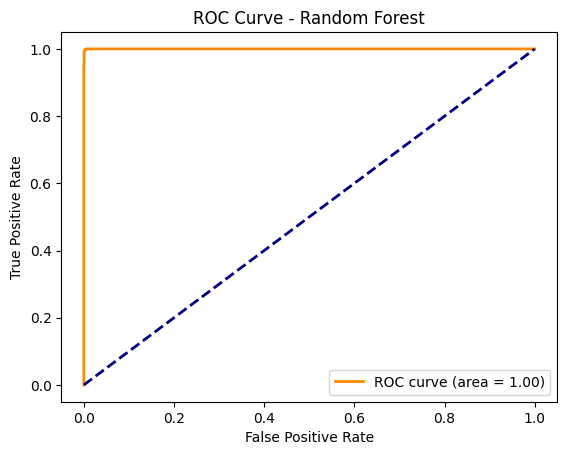

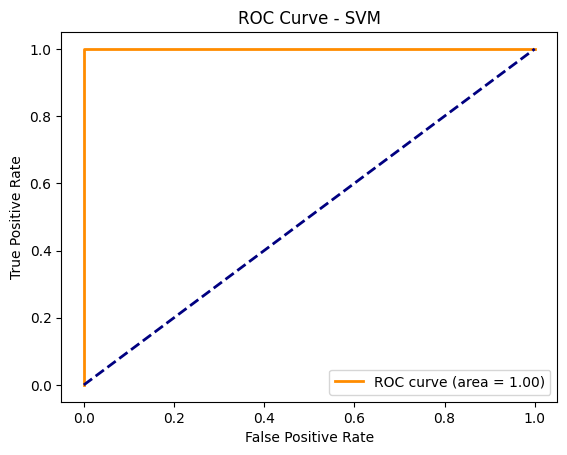

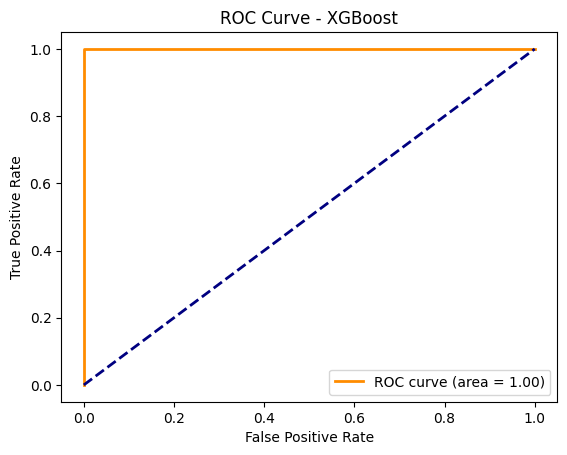

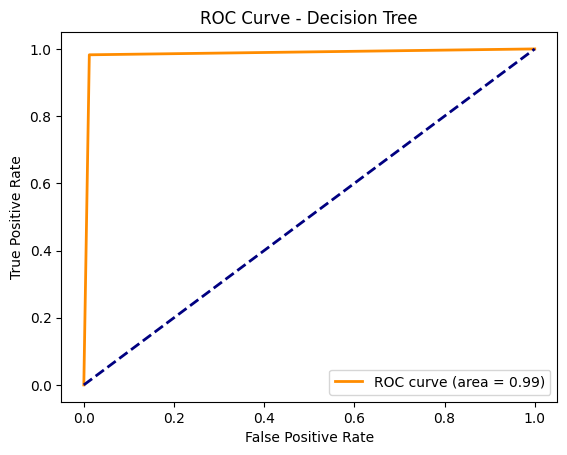

In [17]:
from sklearn.metrics import roc_curve, auc

# ROC Curve ve AUC (Eğer probability kullanılıyorsa)
for model_name, (model, y_pred) in models.items():
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        continue  # ROC sadece olasılık tahmini sağlayan modeller için

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.show()


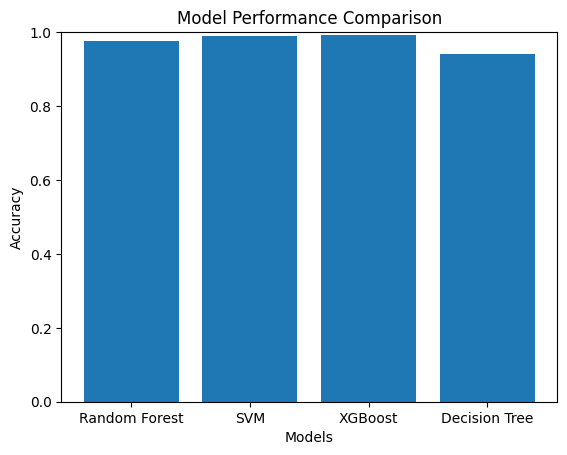

In [21]:
# Modellerin Doğruluk Oranlarını Karşılaştırma
accuracies = {
    "Random Forest": accuracy_score(y_test, rf_y_pred),
    "SVM": accuracy_score(y_test, svm_y_pred),
    "XGBoost": accuracy_score(y_test, xgb_y_pred),
    "Decision Tree": accuracy_score(y_test, dt_y_pred)
}

plt.bar(accuracies.keys(), accuracies.values())
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Performance Comparison")
plt.ylim(0, 1)  # Doğruluk oranı için 0-1 aralığı
plt.show()


# Topluluk Öğrenmesine Geçiş 

In [22]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV

# Hiperparametre Arama - Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200,400, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=48), param_grid_rf, cv=3, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

print("En iyi Random Forest hiperparametreleri:", grid_search_rf.best_params_)
print("En iyi Random Forest doğruluk skoru:", grid_search_rf.best_score_)

// 150 dk ve hala tamamlanmadı

In [23]:
# Hiperparametre Arama - Decision Tree
param_grid_dt = {
    'max_depth': [20,50,100, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=48), param_grid_dt, cv=3, scoring='accuracy')
grid_search_dt.fit(X_train, y_train)

print("En iyi Decision Tree hiperparametreleri:", grid_search_dt.best_params_)
print("En iyi Decision Tree doğruluk skoru:", grid_search_dt.best_score_)


In [ ]:
best_rf_model = grid_search_rf.best_estimator_
best_dt_model = grid_search_dt.best_estimator_

In [25]:
ensemble_model = VotingClassifier(
    estimators=[
        ('Best Random Forest', rf_model),
        ('SVM', svm_model),
        ('XGBoost', xgb_model),
        ('Best Decision Tree', dt_model)
    ],
    voting='soft'
)

ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('Best Random Forest',
                              RandomForestClassifier(random_state=48)),
                             ('SVM', SVC(probability=True, random_state=48)),
                             ('XGBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='l...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...)),
                             ('Best Decision Tree',
                              DecisionTreeClassifier(random_state=48))],
                 voting='soft')

In [27]:
ensemble_y_pred = ensemble_model.predict(X_test)

# Performans değerlendirme
print("Topluluk Öğrenmesi - Doğruluk Oranı:", accuracy_score(y_test, ensemble_y_pred))
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, ensemble_y_pred, digits=6))

Topluluk Öğrenmesi - Doğruluk Oranı: 0.991

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0   0.985075  0.986126  0.985600       937
           1   0.997093  1.000000  0.998544      1029
           2   0.990291  0.986460  0.988372      1034

    accuracy                       0.991000      3000
   macro avg   0.990820  0.990862  0.990839      3000
weighted avg   0.990995  0.991000  0.990995      3000



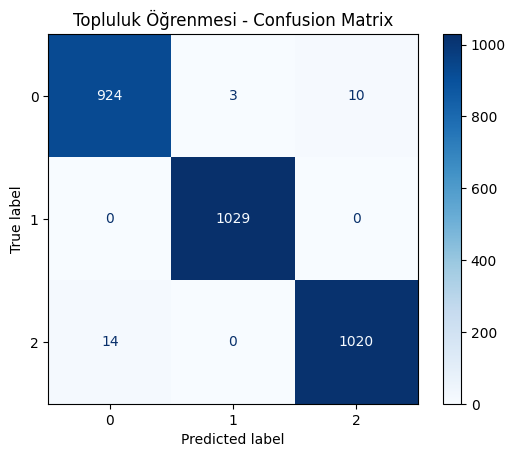

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, ensemble_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Topluluk Öğrenmesi - Confusion Matrix")
plt.show()

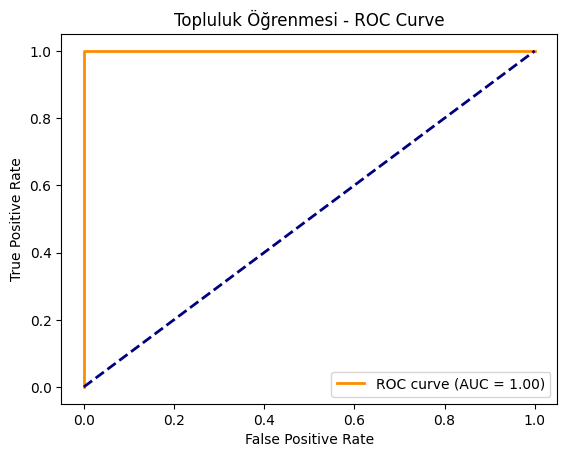

In [29]:
from sklearn.metrics import roc_curve, auc

# Topluluk model ROC eğrisi
y_pred_proba = ensemble_model.predict_proba(X_test)[:, 1]  # Pozitif sınıf olasılıkları
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Topluluk Öğrenmesi - ROC Curve')
plt.legend(loc="lower right")
plt.show()

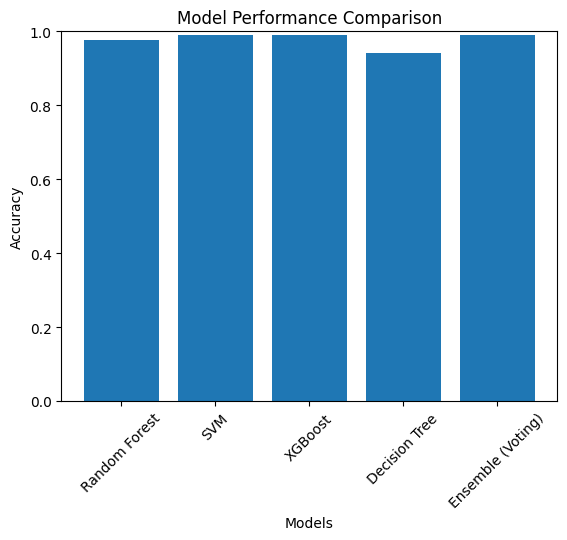

In [30]:
# Performans Karşılaştırma
model_accuracies = {
    "Random Forest": accuracy_score(y_test, rf_model.predict(X_test)),
    "SVM": accuracy_score(y_test, svm_model.predict(X_test)),
    "XGBoost": accuracy_score(y_test, xgb_model.predict(X_test)),
    "Decision Tree": accuracy_score(y_test, dt_model.predict(X_test)),
    "Ensemble (Voting)": accuracy_score(y_test, ensemble_y_pred)
}

plt.bar(model_accuracies.keys(), model_accuracies.values())
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Performance Comparison")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

In [ ]:
model_accuracies.keys() 
model_accuracies.values()